# Multitask model for predict the 3 tasks with different activation layer and weighted loss


In  `MultiTaskLSTM` Model

## **Input**

- **shape**: `(batch_size, seq_len, input_size)`
- **contents**: To capture the time information ，Input contains the surrounding 10 frames information（`context_size=5`），so the `input_size` ：
    \[
    \text{input\_size} = \text{NMELS} \times (2 \times \text{context\_size} + 1) = 128 \times 11 = 1408
    \]
    `NMELS=128` indicates dimension of Mel Band, `context_size=5` contains the mel band of 5 bands before and after the current band.

## **Output**
Multitask model has the same model but for 3 different kind of output:
1. **Presence Prediction**
   - **Shape**: `(batch_size, seq_len, 1)`
   - **内容**: every time step predict the next note, 1 indicate the next note will appear, 0 indicate the next note will not.
   - **激活函数**: Sigmoid，limit the output to `[0, 1]` 

2. **Type Prediction**
   - **形状**: `(batch_size, seq_len, num_types)`
   - **内容**: every time step predict the next note, `num_types` indicate the number of note type
   - **激活函数**: No（The loss is calculates through `CrossEntropyLoss`，which will use `Softmax`）。

3. **Position Prediction**
   - **形状**: `(batch_size, seq_len, 1)`
   - **内容**: every time step predict the next note, usually between `[−1, 1]` 
   - **激活函数**: Tanh，limit the output to `[−1, 1]` 

## Model Strcuture
```
Input: (batch_size, seq_len, 1408) 
     └─> LSTM (Bidirection, hidden_size=128) 
         └─> 输出: (batch_size, seq_len, 256) 
             ├─> fc_presence + Sigmoid → (batch_size, seq_len, 1)
             ├─> fc_type → (batch_size, seq_len, num_types)
             └─> fc_position + Tanh → (batch_size, seq_len, 1)
```

In [1]:
# Cytoid-AI-charting with Difficulty-based Threshold Prediction

# Define imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
import json
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Tuple, Dict, Any
import enum
import tqdm
import pickle  # 用于保存阈值
from sklearn.metrics import f1_score

# STFT variables
SAMPLE_RATE = 22050  
HOP_LENGTH = 512     
NMELS = 128        
FRAME = 20     

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 
# define functions for data processing
#

# Check if string contains non-ASCII characters

def contains_non_ascii(s: str) -> bool:
    return any(ord(c) > 127 for c in s)

# Extract level data from JSON files in the specified directory.
def extract_level_json(directory: Path) -> Dict[str, Any]:
    result = {}
    for folder_path in directory.iterdir():
        json_file_path = folder_path / 'level.json'
        if json_file_path.is_file():
            with json_file_path.open('r', encoding='utf-8') as json_file:
                level_data = json.load(json_file)

            chart_difficulty = level_data['charts'][0].get('difficulty', 0)
            # if chart_difficulty != 15:
                # continue  

            audio_file_name = level_data['music']['path']
            audio_file_extensions = ['.mp3', '.ogg', '.wav']
            audio_file_path = None

            for ext in audio_file_extensions:
                aud_path = folder_path / audio_file_name
                if aud_path.suffix.lower() == ext and aud_path.is_file():
                    audio_file_path = aud_path
                    break
            if audio_file_path is None:
                continue  

            charts_path = folder_path / level_data['charts'][0]['path']
            result[level_data['id']] = {
                'level': level_data,
                'mp3_path': str(audio_file_path),
                'charts_path': str(charts_path),
                'charter': level_data.get('charter', ''),
                'type': level_data['charts'][0].get('type', ''),
                'difficulty': chart_difficulty
            }
    return result

# Extract chart data from a JSON file.
def extract_charts(path: str) -> Dict[str, Any]:
    file_path = Path(path)
    if file_path.exists() and file_path.is_file():
        with open(file_path, 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                return data
            except json.JSONDecodeError:
                print(f"JSON decode error for file: {path}")
    return {}

# Filter songs with constant BPM.
def find_single_tempo_songs(data: Dict[str, Any]) -> List[Dict[str, Any]]:
    single_tempo_songs = []
    for song_id, song in data.items():
        charts_data = extract_charts(song['charts_path'])
        if charts_data and 'tempo_list' in charts_data:
            if len(charts_data['tempo_list']) == 1:
                single_tempo_songs.append(song)
    return single_tempo_songs

# Map notes to their corresponding time positions.
def map_note_to_time(data: Dict[str, Any]) -> List[Dict[str, Any]]:
    time_base = data.get('time_base', 1000) 
    offset_universal = 0.033 
    offset = data.get('music_offset', 0) - offset_universal
    tempo_list = sorted(data.get('tempo_list', []), key=lambda x: x['tick'])  
    note_list = data.get('note_list', [])
    
    note_time_map = []
    accumulated_time = 0 
    last_tick = 0  
    if not tempo_list:
        return note_time_map
    current_tempo = tempo_list[0]['value']  
    tempo_index = 0  

    for note in note_list:
        note_tick = note['tick']
        while tempo_index < len(tempo_list) - 1 and tempo_list[tempo_index + 1]['tick'] <= note_tick:
            next_tempo_tick = tempo_list[tempo_index + 1]['tick']
            ticks_in_interval = next_tempo_tick - last_tick
            tick_duration = (current_tempo / time_base) 
            accumulated_time += ticks_in_interval * tick_duration
            last_tick = next_tempo_tick
            tempo_index += 1
            current_tempo = tempo_list[tempo_index]['value']

        ticks_in_interval = note_tick - last_tick
        tick_duration = (current_tempo / time_base) 
        note_time = accumulated_time + ticks_in_interval * tick_duration
        note_time_map.append({
            'note_id': note.get('id', 0),
            'note_tick': note_tick,
            'note_time_microseconds': note_time - offset * 1_000_000,
            'note_type': note.get('type', 0),
            'note_x': note.get('x', 0.0)
        })

    return note_time_map

# Generate mel spectrogram and corresponding labels from audio file.
def generate_mel_spectrogram(
    audio_path: Path,
    context_size: int = 5,
    log_enable: bool = True,
    bpm_info: List[Dict[str, float]] = None,
    note_info: List[Dict[str, Any]] = None
) -> dict:
    data, sr = librosa.load(str(audio_path), sr=SAMPLE_RATE)
    assert sr == SAMPLE_RATE, f"Expected sample rate {SAMPLE_RATE}, but got {sr}"

    mel = librosa.feature.melspectrogram(
        y=data,
        sr=sr, 
        hop_length=HOP_LENGTH, 
        fmin=30.0, 
        n_mels=NMELS, 
        htk=True
    )
    if log_enable:
        mel = np.log(np.clip(mel, 1e-5, None))
    mel = mel.T  # (时间步, 特征)

    # 构建上下文窗口
    pad_width = context_size
    padded_mel = np.pad(mel, ((pad_width, pad_width), (0, 0)), mode='edge')
    context_mel = np.array([
        padded_mel[i - context_size:i + context_size + 1].flatten()
        for i in range(context_size, len(mel) + context_size)
    ])

    data_dic = {"mel": context_mel}

    if bpm_info and note_info:
        mel_length = mel.shape[0]
        labels = np.zeros((mel_length, 3))  # [presence, type, placement]
        for note in note_info:
            time_sec = note['note_time_microseconds'] / 1_000_000
            frame_idx = int(time_sec * SAMPLE_RATE / HOP_LENGTH)
            if frame_idx < mel_length:
                labels[frame_idx, 0] = 1  # Presence
                labels[frame_idx, 1] = note['note_type']  # Type
                labels[frame_idx, 2] = note['note_x']  # Placement on scanning line
        data_dic["labels"] = labels  # shape: (mel_length, 3)

    return data_dic

class TimeUnit(enum.Enum):
    milliseconds = "milliseconds"
    frames = "frames"
    seconds = "seconds"

# define input dataset
class OnsetDataset(Dataset):
    """
    PyTorch Dataset 类，用于加载和提供数据。
    """
    def __init__(self, data: Dict[str, Any], bpm_info: Dict[str, List[Dict[str, float]]], score_positions: Dict[str, List[Dict[str, Any]]], transform=None):
        self.data = data
        self.bpm_info = bpm_info
        self.score_positions = score_positions
        self.transform = transform
        self.samples = self.prepare_samples()
        
    def prepare_samples(self) -> List[Tuple[np.ndarray, np.ndarray, np.ndarray]]:
        samples = []
        for song_id, song in self.data.items():
            mp3_path = song["mp3_path"]
            charts_path = song["charts_path"]
            difficulty = song['difficulty']  # 提取难度级别

            mel_dict = generate_mel_spectrogram(
                audio_path=Path(mp3_path),
                context_size=5,
                log_enable=True,
                bpm_info=self.bpm_info.get(song_id, None),
                note_info=self.score_positions.get(song_id, None)
            )
            if "labels" in mel_dict:
                mel = mel_dict["mel"]  # shape: (num_frames, context_window_size * n_mels)
                labels = mel_dict["labels"]  # shape: (num_frames, 3)
                # 添加难度级别到每个样本
                difficulty_encoded = self.encode_difficulty(difficulty)
                difficulties = np.full((mel.shape[0], 1), difficulty_encoded)
                samples.append((mel, labels, difficulties))
        return samples
        
    def __len__(self) -> int:
        return len(self.samples)
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mel, labels, difficulties = self.samples[idx]
        mel = torch.from_numpy(mel).float()  # shape: (num_frames, context_window_size * n_mels)
        labels = torch.from_numpy(labels).float()  # shape: (num_frames, 3)
        difficulties = torch.from_numpy(difficulties).float()  # shape: (num_frames, 1)

        if self.transform:
            mel, labels, difficulties = self.transform(mel, labels, difficulties)

        return mel, labels, difficulties

    @staticmethod
    def encode_difficulty(difficulty: Any) -> int:
        difficulty_mapping = {
            'easy': 0,
            'normal': 1,
            'hard': 2,
            'expert': 3,
            'master': 4
            # 根据需要扩展
        }
        if isinstance(difficulty, str):
            return difficulty_mapping.get(difficulty.lower(), 0)  # 默认返回0（easy）
        elif isinstance(difficulty, int):
            return difficulty  # 假设已经编码
        else:
            return 0  # 默认返回0（easy）

# Process BPM information to generate beat arrays
def process_bpminfo(
    bpm_info: List[Dict[str, float]],  
    max_length_ms: int,
    units: TimeUnit = TimeUnit.milliseconds
) -> Tuple[List[float], List[float], List[float], List[int]]:
    bpms, starts, ends, beats = [], [], [], []
    max_length = convert_units(max_length_ms, units)

    for i, tempo_event in enumerate(bpm_info):
        tick = tempo_event['tick']
        value = tempo_event['value']
        start = convert_units(tick * FRAME, TimeUnit.milliseconds) 
        if start > max_length:
            continue
        bpm = 60000000 / value  
        bpms.append(bpm)
        starts.append(start)
        beats.append(4)  # 假设每拍4拍
        if i < len(bpm_info) - 1:
            next_tick = bpm_info[i + 1]['tick']
            next_start = convert_units(next_tick * FRAME, TimeUnit.milliseconds)
            ends.append(min(next_start, max_length))
        else:
            ends.append(max_length)
    
    return bpms, starts, ends, beats

def convert_units(value: float, units: TimeUnit) -> float:
    if units == TimeUnit.milliseconds:
        return float(value)
    elif units == TimeUnit.seconds:
        return float(value) / 1000.0
    elif units == TimeUnit.frames:
        return float(value) * FRAME  
    else:
        raise ValueError("convert_units error")

# Generate array representing beat positions.
def gen_beats_array(
    length: int,
    bpm_info: List[Dict[str, float]],  # tempo_list [{'tick': 0, 'value': 300000}]
    mel_length: int,
    is_downbeat: bool = True,
):
    arr = np.zeros(length)
    bpms, starts, ends, beats = process_bpminfo(
        bpm_info, mel_length * FRAME, units=TimeUnit.milliseconds
    )
    for bpm, start, end, beat in zip(bpms, starts, ends, beats):
        interval = 60000 / bpm  # 毫秒
        beats_timing = np.arange(start, end, interval)
        arg_beats = np.round(beats_timing / FRAME).astype("int64")
        arg_beats = arg_beats[arg_beats < length]  

        for b in range(beat):
            if b == 0:  #
                if is_downbeat:
                    arr[arg_beats[b::beat]] = 2
                else:
                    arr[arg_beats[b::beat]] = 1
            else:  
                arr[arg_beats[b::beat]] = 1

    return arr.reshape([-1, 1])

def add_white_noise(x: np.ndarray, rate: float = 0.005) -> np.ndarray:
    return x + rate * np.random.randn(len(x))

def shift(ar: torch.Tensor, size: int, med: int) -> torch.Tensor:
    if size > 0:
        ar = F.pad(ar[size:], (0, size)) + F.pad(ar[:-size], (size, 0))
    ar = ar * (med - size)
    return ar

def gauss(ar: torch.Tensor, width: int = 3, scale: float = 1.0) -> torch.Tensor:
    t = torch.stack([shift(ar, i, width) for i in range(width)])
    t = torch.max(t, dim=0)[0]
    mask = t == 0
    std = width / 3
    var = std**2
    t2 = torch.exp(-((t - width) ** 2) / (2 * var)) * scale
    return torch.max(t2.masked_fill(mask, 0), ar.float())

def round_decimal(tensor: torch.Tensor, decimals: int) -> torch.Tensor:
    multiplier = 10 ** decimals
    return torch.round(tensor * multiplier) / multiplier

def fuzzy_label(onset_label: torch.Tensor, width: int, scale: float) -> torch.Tensor:
    assert width > 0
    assert 0 <= scale <= 1
    return round_decimal(gauss(onset_label.view(-1), width, scale), 2).view(len(onset_label), 1)

def fuzzy_on_batch(batch: torch.Tensor, width: int, scale: float) -> torch.Tensor:
    fuzzy_labeled = []
    for x in range(batch.shape[0]):
        fuzzy_labeled.append(fuzzy_label(batch[x], width, scale))
    return torch.stack(fuzzy_labeled)

# define functions for model
def collate_fn_padded(batch: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, List[int]]:
    mel, labels, difficulties = zip(*batch)
    lengths = [m.shape[0] for m in mel]
    
    # Pad Mel spectrograms and difficulties
    mel_padded = pad_sequence(mel, batch_first=True, padding_value=0)  # (batch_size, max_seq_len, input_size)
    difficulties_padded = pad_sequence(difficulties, batch_first=True, padding_value=0)  # (batch_size, max_seq_len, 1)
    
    # Pad labels
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)  # (batch_size, max_seq_len, 3)
    
    return mel_padded, labels_padded, difficulties_padded, lengths

def multi_task_loss(presence_pred, type_pred, position_pred, presence_target, type_target, position_target, num_types=5):
    # 是否出现的损失（二元交叉熵）
    loss_presence = nn.BCELoss()(presence_pred, presence_target)

    # 事件种类的损失（交叉熵）
    # Reshape for CrossEntropyLoss: (batch_size * seq_len, num_types)
    type_pred = type_pred.view(-1, num_types)
    type_target = type_target.view(-1).long()
    loss_type = nn.CrossEntropyLoss()(type_pred, type_target)

    # 事件位置的损失（均方误差）
    # loss_position = nn.MSELoss()(position_pred, position_target)
    loss_position = 0  # 当前未使用位置损失

    # 总损失，可以根据需要调整权重
    total_loss = loss_presence + loss_type + loss_position
    return total_loss

class MultiTaskLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, num_types: int, dropout: float = 0.5):
        super(MultiTaskLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # 输出层
        self.fc_presence = nn.Linear(hidden_size * 2, 1)  # 是否出现（0/1）
        self.fc_type = nn.Linear(hidden_size * 2, num_types)  # 事件种类（多类别）
        self.fc_position = nn.Linear(hidden_size * 2, 1)  # 事件位置（0-1）

        # 激活函数
        self.sigmoid = nn.Sigmoid()
        # 注意：CrossEntropyLoss 期望原始 logits，因此不应用 Softmax
        self.tanh = nn.Tanh()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_size * 2)

        # 是否出现
        presence_out = self.sigmoid(self.fc_presence(lstm_out))  # (batch_size, seq_len, 1)

        # 事件种类
        type_out = self.fc_type(lstm_out)  # (batch_size, seq_len, num_types)

        # 事件位置
        position_out = self.tanh(self.fc_position(lstm_out))  # (batch_size, seq_len, 1)

        return presence_out, type_out, position_out

def visualize_predictions(mel: np.ndarray, labels: np.ndarray, preds: Tuple[np.ndarray, np.ndarray, np.ndarray], start_time: float = 0, end_time: float = 5):
    presence_pred, type_pred, position_pred = preds

    # 计算时间轴
    total_time = mel.shape[0] * HOP_LENGTH / SAMPLE_RATE
    times = np.linspace(0, total_time, num=mel.shape[0])

    # 确定可视化的帧范围
    start_frame = int(start_time * SAMPLE_RATE / HOP_LENGTH)
    end_frame = int(end_time * SAMPLE_RATE / HOP_LENGTH)

    # 裁剪数据
    mel_cropped = mel[start_frame:end_frame]
    labels_cropped = labels[start_frame:end_frame]
    presence_pred_cropped = presence_pred[start_frame:end_frame]
    type_pred_cropped = type_pred[start_frame:end_frame]
    position_pred_cropped = position_pred[start_frame:end_frame]

    # 创建子图
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 绘制Mel频谱图
    img = librosa.display.specshow(
        mel_cropped.T,
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        x_coords=times[start_frame:end_frame],
        ax=axs[0],
        x_axis='time',
        y_axis='mel',
        fmax=8000
    )
    axs[0].set_title('Mel Spectrogram')
    fig.colorbar(img, ax=axs[0], format='%+2.0f dB')

    # 绘制Presence预测与真实标签
    axs[1].plot(
        times[start_frame:end_frame],
        presence_pred_cropped.flatten(),
        label='Presence Prediction',
        color='red',
        alpha=0.6
    )
    axs[1].plot(
        times[start_frame:end_frame],
        labels_cropped[:, 0],
        label='Presence Ground Truth',
        color='blue',
        linestyle='dashed'
    )

    # 绘制Type预测与真实标签
    # 假设type_pred是类别的概率分布，这里我们取概率最高的类别
    type_pred_labels = np.argmax(type_pred_cropped, axis=-1)
    type_target_labels = labels_cropped[:, 1].astype(int)

    # 绘制Type Ground Truth
    axs[1].scatter(
        times[start_frame:end_frame],
        labels_cropped[:, 2],  # 位置
        label='Type Ground Truth',
        color='green',
        marker='x'
    )

    # 绘制Type Prediction（可以根据需要调整）
    axs[1].scatter(
        times[start_frame:end_frame],
        position_pred_cropped.flatten(),  # 位置预测
        label='Position Prediction',
        color='orange',
        marker='o',
        alpha=0.6
    )

    axs[1].set_title('Predictions vs Ground Truth')
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Presence / Position')

    plt.tight_layout()
    plt.show()

def visualize_predictions_with_threshold(mel: np.ndarray, labels: np.ndarray, preds: Tuple[np.ndarray, np.ndarray, np.ndarray], difficulty: int, threshold: float, start_time: float = 0, end_time: float = 5):
    presence_pred, type_pred, position_pred = preds

    # 应用阈值
    presence_final = (presence_pred >= threshold).astype(int)

    # 计算时间轴
    total_time = mel.shape[0] * HOP_LENGTH / SAMPLE_RATE
    times = np.linspace(0, total_time, num=mel.shape[0])

    # 确定可视化的帧范围
    start_frame = int(start_time * SAMPLE_RATE / HOP_LENGTH)
    end_frame = int(end_time * SAMPLE_RATE / HOP_LENGTH)

    # 裁剪数据
    mel_cropped = mel[start_frame:end_frame]
    labels_cropped = labels[start_frame:end_frame]
    presence_pred_cropped = presence_pred[start_frame:end_frame]
    presence_final_cropped = presence_final[start_frame:end_frame]
    type_pred_cropped = type_pred[start_frame:end_frame]
    position_pred_cropped = position_pred[start_frame:end_frame]

    # 创建子图
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 绘制Mel频谱图
    img = librosa.display.specshow(
        mel_cropped.T,
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        x_coords=times[start_frame:end_frame],
        ax=axs[0],
        x_axis='time',
        y_axis='mel',
        fmax=8000
    )
    axs[0].set_title('Mel Spectrogram')
    fig.colorbar(img, ax=axs[0], format='%+2.0f dB')

    # 绘制Presence预测与真实标签
    axs[1].plot(
        times[start_frame:end_frame],
        presence_pred_cropped.flatten(),
        label='Presence Prediction (Raw)',
        color='red',
        alpha=0.6
    )
    axs[1].plot(
        times[start_frame:end_frame],
        presence_final_cropped,
        label=f'Presence Prediction (Threshold={threshold:.2f})',
        color='orange',
        alpha=0.6
    )
    axs[1].plot(
        times[start_frame:end_frame],
        labels_cropped[:, 0],
        label='Presence Ground Truth',
        color='blue',
        linestyle='dashed'
    )

    # 绘制Type预测与真实标签
    # 假设type_pred是类别的概率分布，这里我们取概率最高的类别
    type_pred_labels = np.argmax(type_pred_cropped, axis=-1)
    type_target_labels = labels_cropped[:, 1].astype(int)

    # 绘制Type Ground Truth
    axs[1].scatter(
        times[start_frame:end_frame],
        labels_cropped[:, 2],  # 位置
        label='Type Ground Truth',
        color='green',
        marker='x'
    )

    # 绘制Type Prediction（可以根据需要调整）
    axs[1].scatter(
        times[start_frame:end_frame],
        position_pred_cropped.flatten(),  # 位置预测
        label='Position Prediction',
        color='orange',
        marker='o',
        alpha=0.6
    )

    axs[1].set_title(f'Predictions vs Ground Truth (Difficulty: {difficulty}, Threshold: {threshold:.2f})')
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Presence / Position')

    plt.tight_layout()
    plt.show()

def train_epoch(model: nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, device: torch.device, num_types: int) -> float:
    model.train()
    running_loss = 0.0
    progress_bar = tqdm.tqdm(dataloader, desc="Training", leave=False)

    for mel, labels, difficulties, lengths in progress_bar:
        mel = mel.to(device)  # (batch_size, seq_len, input_size)
        labels = labels.to(device)  # (batch_size, seq_len, 3)
        difficulties = difficulties.to(device)  # (batch_size, seq_len, 1)

        # 拆分标签
        presence_target = labels[:, :, 0].unsqueeze(-1)  # (batch_size, seq_len, 1)
        type_target = labels[:, :, 1].long()  # (batch_size, seq_len)
        position_target = labels[:, :, 2].unsqueeze(-1)  # (batch_size, seq_len, 1)

        optimizer.zero_grad()

        # 前向传播
        presence_pred, type_pred, position_pred = model(mel)

        # 计算损失
        loss = multi_task_loss(presence_pred, type_pred, position_pred, presence_target, type_target, position_target, num_types)

        # 反向传播
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss

def validate_epoch(model: nn.Module, dataloader: DataLoader, device: torch.device, num_types: int) -> Tuple[float, Dict[int, Dict[str, List[Any]]]]:
    model.eval()
    running_loss = 0.0
    difficulty_preds = defaultdict(lambda: {'y_true': [], 'y_scores': []})
    progress_bar = tqdm.tqdm(dataloader, desc="Validation", leave=False)

    with torch.no_grad():
        for mel, labels, difficulties, lengths in progress_bar:
            mel = mel.to(device)
            labels = labels.to(device)
            difficulties = difficulties.to(device)

            # 拆分标签
            presence_target = labels[:, :, 0].unsqueeze(-1)
            type_target = labels[:, :, 1].long()
            position_target = labels[:, :, 2].unsqueeze(-1)

            # 前向传播
            presence_pred, type_pred, position_pred = model(mel)

            # 计算损失
            loss = multi_task_loss(presence_pred, type_pred, position_pred, presence_target, type_target, position_target, num_types)

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

            # 收集预测分数和真实标签，按难度级别分组
            # 假设difficulty是编码后的整数
            difficulties_np = difficulties.cpu().numpy().flatten()
            presence_pred_np = presence_pred.cpu().numpy().flatten()
            presence_target_np = presence_target.cpu().numpy().flatten()

            for diff, pred, true in zip(difficulties_np, presence_pred_np, presence_target_np):
                difficulty_preds[diff]['y_true'].append(int(true))
                difficulty_preds[diff]['y_scores'].append(float(pred))

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss, difficulty_preds

def compute_thresholds(difficulty_preds: Dict[int, Dict[str, List[Any]]]) -> Dict[int, float]:
    thresholds = {}
    for diff, data in difficulty_preds.items():
        y_true = np.array(data['y_true'])
        y_scores = np.array(data['y_scores'])
        best_f1 = 0.0
        best_threshold = 0.5
        for threshold in np.linspace(0.1, 0.9, 81):
            y_pred = (y_scores >= threshold).astype(int)
            # 设置 zero_division=0 以避免警告
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        thresholds[diff] = best_threshold
        print(f"Difficulty {diff}: Best Threshold = {best_threshold:.2f}, F1 Score = {best_f1:.4f}")
    return thresholds

def save_thresholds(thresholds: Dict[int, float], filepath: str):
    """保存阈值到文件。"""
    with open(filepath, 'wb') as f:
        pickle.dump(thresholds, f)

def load_thresholds(filepath: str) -> Dict[int, float]:
    """从文件加载阈值。"""
    with open(filepath, 'rb') as f:
        thresholds = pickle.load(f)
    return thresholds

def evaluate_test_set(model: nn.Module, dataloader: DataLoader, device: torch.device, num_types: int, thresholds: Dict[int, float]):
    model.eval()
    all_metrics = defaultdict(list)
    difficulty_metrics = defaultdict(lambda: {'y_true': [], 'y_pred': []})
    progress_bar = tqdm.tqdm(dataloader, desc="Testing", leave=False)

    with torch.no_grad():
        for mel, labels, difficulties, lengths in progress_bar:
            mel = mel.to(device)
            labels = labels.to(device)
            difficulties = difficulties.to(device)

            # 拆分标签
            presence_target = labels[:, :, 0].unsqueeze(-1)
            type_target = labels[:, :, 1].long()
            position_target = labels[:, :, 2].unsqueeze(-1)

            # 前向传播
            presence_pred, type_pred, position_pred = model(mel)

            # 收集预测分数和真实标签，按难度级别分组
            difficulties_np = difficulties.cpu().numpy().flatten()
            presence_pred_np = presence_pred.cpu().numpy().flatten()
            presence_target_np = presence_target.cpu().numpy().flatten()

            for diff, pred, true in zip(difficulties_np, presence_pred_np, presence_target_np):
                threshold = thresholds.get(int(diff), 0.5)  # 默认阈值为0.5
                y_pred = 1 if pred >= threshold else 0
                difficulty_metrics[diff]['y_true'].append(int(true))
                difficulty_metrics[diff]['y_pred'].append(int(y_pred))

    # 计算每个难度级别的指标
    final_metrics = {}
    for diff, metrics in difficulty_metrics.items():
        y_true = np.array(metrics['y_true'])
        y_pred = np.array(metrics['y_pred'])
        acc = np.mean(y_pred == y_true)
        precision = np.sum((y_pred == 1) & (y_true == 1)) / max(np.sum(y_pred == 1), 1)
        recall = np.sum((y_pred == 1) & (y_true == 1)) / max(np.sum(y_true == 1), 1)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        final_metrics[diff] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        print(f"Difficulty {diff}: Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

    return final_metrics

# data preprcessing
current_directory = Path().cwd()
data = extract_level_json(current_directory / "dataset/Z")
print(f"Filtered Data Count (Difficulty=15): {len(data)}")
bpm_info_dict = {}
score_positions_dict = {}

# extract the bpm info and note info
for song_id, song in data.items():
    song_id = song['level']['id']
    charts_data = extract_charts(song['charts_path'])
    if charts_data:
        bpm_info = charts_data.get('tempo_list', [])
        bpm_info_dict[song_id] = bpm_info
        note_time_map = map_note_to_time(charts_data) 
        # 每个音符的详细信息，包括时间、类型和位置
        score_positions = [] 
        for note in note_time_map:
            score_positions.append({
                'note_time_microseconds': note['note_time_microseconds'],
                'note_type': note['note_type'],  # 确保此字段存在
                'note_x': note['note_x']         # 确保此字段存在
            })
        score_positions_dict[song_id] = score_positions


input_size = NMELS * (2 * 5 + 1)  # context_size=5, so window=11, input_size=128*11=1408
hidden_size = 128
num_layers = 2
num_types = 8  # There are 8 differenct note types in Ctyoid the game
dropout = 0.5
num_epochs = 50
batch_size = 16
learning_rate = 0.001

single_tempo_data = find_single_tempo_songs(data)
print(f"Total songs: {len(data)}")
print(f"Single tempo songs: {len(single_tempo_data)}")

# 创建一个新的字典，只包含single tempo的歌曲数据
single_tempo_dict = {song['level']['id']: song for song in single_tempo_data}
filtered_bpm_info_dict = {k: v for k, v in bpm_info_dict.items() if k in single_tempo_dict}
filtered_score_positions_dict = {k: v for k, v in score_positions_dict.items() if k in single_tempo_dict}
dataset = OnsetDataset(
    data=single_tempo_dict,
    bpm_info=filtered_bpm_info_dict,
    score_positions=filtered_score_positions_dict,
)

# dataset = OnsetDataset(
#     data=data, 
#     bpm_info=bpm_info_dict, 
#     score_positions=score_positions_dict,
# )
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn_padded)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn_padded)

print(f"Train Size: {len(train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")

model = MultiTaskLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_types=num_types, dropout=dropout)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
best_val_loss = float('inf')
thresholds_filepath = "difficulty_thresholds.pkl"

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # 训练
    train_loss = train_epoch(model, train_loader, optimizer, device, num_types)
    print(f"Train Loss: {train_loss:.4f}")

    # 验证
    val_loss, val_difficulty_preds = validate_epoch(model, val_loader, device, num_types)
    print(f"Validation Loss: {val_loss:.4f}")

    # 如果验证损失更低，则保存模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_multitask_lstm_model.pth")
        print("Saved Best Model")

    # 计算并保存阈值
    thresholds = compute_thresholds(val_difficulty_preds)
    save_thresholds(thresholds, thresholds_filepath)
    print(f"Saved Thresholds to {thresholds_filepath}")

model.load_state_dict(torch.load("best_multitask_lstm_model.pth"))
model.to(device)
model.eval()
thresholds = load_thresholds(thresholds_filepath)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn_padded)
test_metrics = evaluate_test_set(model, test_loader, device, num_types, thresholds)


Using device: cuda
Filtered Data Count (Difficulty=15): 136
Total songs: 136
Single tempo songs: 66
Train Size: 52
Validation Size: 14
Epoch 1/50


Train Loss: 2.4322


Validation Loss: 1.6373
Saved Best Model
Difficulty 15.0: Best Threshold = 0.34, F1 Score = 0.3103
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.35, F1 Score = 0.2658
Difficulty 13.0: Best Threshold = 0.35, F1 Score = 0.2603
Difficulty 11.0: Best Threshold = 0.37, F1 Score = 0.2333
Difficulty 16.0: Best Threshold = 0.33, F1 Score = 0.3302
Difficulty 9.0: Best Threshold = 0.31, F1 Score = 0.1486
Saved Thresholds to difficulty_thresholds.pkl
Epoch 2/50


Train Loss: 1.6811


Validation Loss: 1.1866
Saved Best Model
Difficulty 15.0: Best Threshold = 0.14, F1 Score = 0.2776
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.10, F1 Score = 0.2403
Difficulty 13.0: Best Threshold = 0.10, F1 Score = 0.2395
Difficulty 11.0: Best Threshold = 0.16, F1 Score = 0.2037
Difficulty 16.0: Best Threshold = 0.14, F1 Score = 0.3100
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1478
Saved Thresholds to difficulty_thresholds.pkl
Epoch 3/50


Train Loss: 1.2584


Validation Loss: 1.0115
Saved Best Model
Difficulty 15.0: Best Threshold = 0.10, F1 Score = 0.0092
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.10, F1 Score = 0.0132
Difficulty 13.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 11.0: Best Threshold = 0.10, F1 Score = 0.0573
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.0005
Difficulty 9.0: Best Threshold = 0.50, F1 Score = 0.0000
Saved Thresholds to difficulty_thresholds.pkl
Epoch 4/50


Train Loss: 0.8006


Validation Loss: 0.7572
Saved Best Model
Difficulty 15.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 13.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 11.0: Best Threshold = 0.10, F1 Score = 0.0113
Difficulty 16.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 9.0: Best Threshold = 0.50, F1 Score = 0.0000
Saved Thresholds to difficulty_thresholds.pkl
Epoch 5/50


Train Loss: 0.5634


Validation Loss: 0.7285
Saved Best Model
Difficulty 15.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 13.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 11.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 16.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 9.0: Best Threshold = 0.50, F1 Score = 0.0000
Saved Thresholds to difficulty_thresholds.pkl
Epoch 6/50


Train Loss: 0.5602


Validation Loss: 0.6872
Saved Best Model
Difficulty 15.0: Best Threshold = 0.10, F1 Score = 0.2877
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.10, F1 Score = 0.2535
Difficulty 13.0: Best Threshold = 0.10, F1 Score = 0.1722
Difficulty 11.0: Best Threshold = 0.11, F1 Score = 0.2064
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3041
Difficulty 9.0: Best Threshold = 0.50, F1 Score = 0.0000
Saved Thresholds to difficulty_thresholds.pkl
Epoch 7/50


Train Loss: 0.6048


Validation Loss: 0.6364
Saved Best Model
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3113
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.12, F1 Score = 0.2853
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.2677
Difficulty 11.0: Best Threshold = 0.16, F1 Score = 0.2010
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3357
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1515
Saved Thresholds to difficulty_thresholds.pkl
Epoch 8/50


Train Loss: 0.4801


Validation Loss: 0.5941
Saved Best Model
Difficulty 15.0: Best Threshold = 0.17, F1 Score = 0.3118
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.14, F1 Score = 0.2865
Difficulty 13.0: Best Threshold = 0.17, F1 Score = 0.2699
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.2008
Difficulty 16.0: Best Threshold = 0.13, F1 Score = 0.3386
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1540
Saved Thresholds to difficulty_thresholds.pkl
Epoch 9/50


Train Loss: 0.4728


Validation Loss: 0.5644
Saved Best Model
Difficulty 15.0: Best Threshold = 0.16, F1 Score = 0.3117
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.18, F1 Score = 0.2862
Difficulty 13.0: Best Threshold = 0.17, F1 Score = 0.2685
Difficulty 11.0: Best Threshold = 0.21, F1 Score = 0.1999
Difficulty 16.0: Best Threshold = 0.12, F1 Score = 0.3376
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1444
Saved Thresholds to difficulty_thresholds.pkl
Epoch 10/50


Train Loss: 0.4779


Validation Loss: 0.5550
Saved Best Model
Difficulty 15.0: Best Threshold = 0.14, F1 Score = 0.3118
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.15, F1 Score = 0.2868
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.2708
Difficulty 11.0: Best Threshold = 0.19, F1 Score = 0.2046
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3370
Difficulty 9.0: Best Threshold = 0.50, F1 Score = 0.0000
Saved Thresholds to difficulty_thresholds.pkl
Epoch 11/50


Train Loss: 0.4617


Validation Loss: 0.5581
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3110
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.14, F1 Score = 0.2870
Difficulty 13.0: Best Threshold = 0.13, F1 Score = 0.2682
Difficulty 11.0: Best Threshold = 0.17, F1 Score = 0.2062
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3310
Difficulty 9.0: Best Threshold = 0.50, F1 Score = 0.0000
Saved Thresholds to difficulty_thresholds.pkl
Epoch 12/50


Train Loss: 0.4794


Validation Loss: 0.5579
Difficulty 15.0: Best Threshold = 0.12, F1 Score = 0.3116
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.12, F1 Score = 0.2865
Difficulty 13.0: Best Threshold = 0.12, F1 Score = 0.2727
Difficulty 11.0: Best Threshold = 0.16, F1 Score = 0.2047
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3314
Difficulty 9.0: Best Threshold = 0.50, F1 Score = 0.0000
Saved Thresholds to difficulty_thresholds.pkl
Epoch 13/50


Train Loss: 0.5121


Validation Loss: 0.5527
Saved Best Model
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3120
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.10, F1 Score = 0.2872
Difficulty 13.0: Best Threshold = 0.13, F1 Score = 0.2738
Difficulty 11.0: Best Threshold = 0.17, F1 Score = 0.2131
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3355
Difficulty 9.0: Best Threshold = 0.50, F1 Score = 0.0000
Saved Thresholds to difficulty_thresholds.pkl
Epoch 14/50


Train Loss: 0.4127


Validation Loss: 0.5503
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3116
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.11, F1 Score = 0.2899
Difficulty 13.0: Best Threshold = 0.15, F1 Score = 0.2684
Difficulty 11.0: Best Threshold = 0.18, F1 Score = 0.2293
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3418
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0083
Saved Thresholds to difficulty_thresholds.pkl
Epoch 15/50


Train Loss: 0.4561


Validation Loss: 0.5510
Difficulty 15.0: Best Threshold = 0.16, F1 Score = 0.3118
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.12, F1 Score = 0.2891
Difficulty 13.0: Best Threshold = 0.16, F1 Score = 0.2783
Difficulty 11.0: Best Threshold = 0.19, F1 Score = 0.2131
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3422
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0827
Saved Thresholds to difficulty_thresholds.pkl
Epoch 16/50


Train Loss: 0.4374


Validation Loss: 0.5529
Difficulty 15.0: Best Threshold = 0.16, F1 Score = 0.3117
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.13, F1 Score = 0.2912
Difficulty 13.0: Best Threshold = 0.17, F1 Score = 0.2748
Difficulty 11.0: Best Threshold = 0.19, F1 Score = 0.2133
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3438
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0729
Saved Thresholds to difficulty_thresholds.pkl
Epoch 17/50


Train Loss: 0.4303


Validation Loss: 0.5546
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3115
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.16, F1 Score = 0.2900
Difficulty 13.0: Best Threshold = 0.16, F1 Score = 0.2764
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.2151
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3418
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0264
Saved Thresholds to difficulty_thresholds.pkl
Epoch 18/50


Train Loss: 0.4374


Validation Loss: 0.5535
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3112
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.16, F1 Score = 0.2908
Difficulty 13.0: Best Threshold = 0.15, F1 Score = 0.2750
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.2190
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3445
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0226
Saved Thresholds to difficulty_thresholds.pkl
Epoch 19/50


Train Loss: 0.4434


Validation Loss: 0.5520
Difficulty 15.0: Best Threshold = 0.14, F1 Score = 0.3121
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.12, F1 Score = 0.2924
Difficulty 13.0: Best Threshold = 0.15, F1 Score = 0.2773
Difficulty 11.0: Best Threshold = 0.18, F1 Score = 0.2152
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3463
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0156
Saved Thresholds to difficulty_thresholds.pkl
Epoch 20/50


Train Loss: 0.4369


Validation Loss: 0.5503
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3136
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.12, F1 Score = 0.2930
Difficulty 13.0: Best Threshold = 0.15, F1 Score = 0.2793
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.2172
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3484
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0244
Saved Thresholds to difficulty_thresholds.pkl
Epoch 21/50


Train Loss: 0.4580


Validation Loss: 0.5496
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3168
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.15, F1 Score = 0.3015
Difficulty 13.0: Best Threshold = 0.15, F1 Score = 0.2815
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.2329
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3478
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0299
Saved Thresholds to difficulty_thresholds.pkl
Epoch 22/50


Train Loss: 0.4445


Validation Loss: 0.5491
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3183
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.15, F1 Score = 0.3026
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.2822
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.2602
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3480
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0352
Saved Thresholds to difficulty_thresholds.pkl
Epoch 23/50


Train Loss: 0.4192


Validation Loss: 0.5483
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3211
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.15, F1 Score = 0.2989
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.2878
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.2677
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3491
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0611
Saved Thresholds to difficulty_thresholds.pkl
Epoch 24/50


Train Loss: 0.4305


Validation Loss: 0.5470
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3227
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.15, F1 Score = 0.3123
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.2953
Difficulty 11.0: Best Threshold = 0.18, F1 Score = 0.2745
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3508
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0810
Saved Thresholds to difficulty_thresholds.pkl
Epoch 25/50


Train Loss: 0.4002


Validation Loss: 0.5462
Saved Best Model
Difficulty 15.0: Best Threshold = 0.16, F1 Score = 0.3218
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.16, F1 Score = 0.3322
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.2974
Difficulty 11.0: Best Threshold = 0.19, F1 Score = 0.2856
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3532
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0836
Saved Thresholds to difficulty_thresholds.pkl
Epoch 26/50


Train Loss: 0.4123


Validation Loss: 0.5459
Saved Best Model
Difficulty 15.0: Best Threshold = 0.16, F1 Score = 0.3233
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.16, F1 Score = 0.3257
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.3015
Difficulty 11.0: Best Threshold = 0.19, F1 Score = 0.2972
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3529
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0837
Saved Thresholds to difficulty_thresholds.pkl
Epoch 27/50


Train Loss: 0.4170


Validation Loss: 0.5451
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3258
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.15, F1 Score = 0.3354
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.3106
Difficulty 11.0: Best Threshold = 0.19, F1 Score = 0.3217
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3551
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0794
Saved Thresholds to difficulty_thresholds.pkl
Epoch 28/50


Train Loss: 0.4098


Validation Loss: 0.5441
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3296
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.17, F1 Score = 0.3458
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.3092
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.3306
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3570
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0792
Saved Thresholds to difficulty_thresholds.pkl
Epoch 29/50


Train Loss: 0.4258


Validation Loss: 0.5435
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3325
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.16, F1 Score = 0.3563
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.3069
Difficulty 11.0: Best Threshold = 0.21, F1 Score = 0.3391
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3577
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.0839
Saved Thresholds to difficulty_thresholds.pkl
Epoch 30/50


Train Loss: 0.4091


Validation Loss: 0.5423
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3352
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.16, F1 Score = 0.3739
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.3101
Difficulty 11.0: Best Threshold = 0.21, F1 Score = 0.3459
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3598
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1122
Saved Thresholds to difficulty_thresholds.pkl
Epoch 31/50


Train Loss: 0.3955


Validation Loss: 0.5425
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3371
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.17, F1 Score = 0.3882
Difficulty 13.0: Best Threshold = 0.13, F1 Score = 0.3152
Difficulty 11.0: Best Threshold = 0.23, F1 Score = 0.3571
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3595
Difficulty 9.0: Best Threshold = 0.11, F1 Score = 0.0896
Saved Thresholds to difficulty_thresholds.pkl
Epoch 32/50


Train Loss: 0.4185


Validation Loss: 0.5428
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3409
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.18, F1 Score = 0.4011
Difficulty 13.0: Best Threshold = 0.12, F1 Score = 0.3138
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.3635
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3626
Difficulty 9.0: Best Threshold = 0.12, F1 Score = 0.0935
Saved Thresholds to difficulty_thresholds.pkl
Epoch 33/50


Train Loss: 0.4758


Validation Loss: 0.5380
Saved Best Model
Difficulty 15.0: Best Threshold = 0.14, F1 Score = 0.3399
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.21, F1 Score = 0.4067
Difficulty 13.0: Best Threshold = 0.15, F1 Score = 0.3188
Difficulty 11.0: Best Threshold = 0.24, F1 Score = 0.3651
Difficulty 16.0: Best Threshold = 0.12, F1 Score = 0.3674
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1261
Saved Thresholds to difficulty_thresholds.pkl
Epoch 34/50


Train Loss: 0.4189


Validation Loss: 0.5391
Difficulty 15.0: Best Threshold = 0.14, F1 Score = 0.3431
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.19, F1 Score = 0.4085
Difficulty 13.0: Best Threshold = 0.12, F1 Score = 0.3227
Difficulty 11.0: Best Threshold = 0.22, F1 Score = 0.3721
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3666
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1138
Saved Thresholds to difficulty_thresholds.pkl
Epoch 35/50


Train Loss: 0.4166


Validation Loss: 0.5383
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3414
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.21, F1 Score = 0.4131
Difficulty 13.0: Best Threshold = 0.14, F1 Score = 0.3291
Difficulty 11.0: Best Threshold = 0.22, F1 Score = 0.3891
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3665
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1418
Saved Thresholds to difficulty_thresholds.pkl
Epoch 36/50


Train Loss: 0.4269


Validation Loss: 0.5388
Difficulty 15.0: Best Threshold = 0.14, F1 Score = 0.3439
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.20, F1 Score = 0.4166
Difficulty 13.0: Best Threshold = 0.13, F1 Score = 0.3282
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.3842
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3703
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1204
Saved Thresholds to difficulty_thresholds.pkl
Epoch 37/50


Train Loss: 0.3953


Validation Loss: 0.5382
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3468
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.20, F1 Score = 0.4174
Difficulty 13.0: Best Threshold = 0.13, F1 Score = 0.3274
Difficulty 11.0: Best Threshold = 0.23, F1 Score = 0.3823
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3701
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1395
Saved Thresholds to difficulty_thresholds.pkl
Epoch 38/50


Train Loss: 0.4010


Validation Loss: 0.5409
Difficulty 15.0: Best Threshold = 0.11, F1 Score = 0.3505
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.20, F1 Score = 0.4158
Difficulty 13.0: Best Threshold = 0.12, F1 Score = 0.3235
Difficulty 11.0: Best Threshold = 0.21, F1 Score = 0.3749
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3718
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1257
Saved Thresholds to difficulty_thresholds.pkl
Epoch 39/50


Train Loss: 0.4333


Validation Loss: 0.5344
Saved Best Model
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3487
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.24, F1 Score = 0.4165
Difficulty 13.0: Best Threshold = 0.15, F1 Score = 0.3265
Difficulty 11.0: Best Threshold = 0.23, F1 Score = 0.3602
Difficulty 16.0: Best Threshold = 0.13, F1 Score = 0.3741
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1524
Saved Thresholds to difficulty_thresholds.pkl
Epoch 40/50


Train Loss: 0.4282


Validation Loss: 0.5490
Difficulty 15.0: Best Threshold = 0.10, F1 Score = 0.3562
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.16, F1 Score = 0.4219
Difficulty 13.0: Best Threshold = 0.11, F1 Score = 0.3222
Difficulty 11.0: Best Threshold = 0.20, F1 Score = 0.3947
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3603
Difficulty 9.0: Best Threshold = 0.14, F1 Score = 0.1016
Saved Thresholds to difficulty_thresholds.pkl
Epoch 41/50


Train Loss: 0.4296


Validation Loss: 0.5348
Difficulty 15.0: Best Threshold = 0.18, F1 Score = 0.3443
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.25, F1 Score = 0.4315
Difficulty 13.0: Best Threshold = 0.16, F1 Score = 0.3315
Difficulty 11.0: Best Threshold = 0.28, F1 Score = 0.3906
Difficulty 16.0: Best Threshold = 0.16, F1 Score = 0.3730
Difficulty 9.0: Best Threshold = 0.14, F1 Score = 0.1577
Saved Thresholds to difficulty_thresholds.pkl
Epoch 42/50


Train Loss: 0.4320


Validation Loss: 0.5445
Difficulty 15.0: Best Threshold = 0.11, F1 Score = 0.3597
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.18, F1 Score = 0.4331
Difficulty 13.0: Best Threshold = 0.10, F1 Score = 0.3258
Difficulty 11.0: Best Threshold = 0.23, F1 Score = 0.4089
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3707
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1003
Saved Thresholds to difficulty_thresholds.pkl
Epoch 43/50


Train Loss: 0.4392


Validation Loss: 0.5347
Difficulty 15.0: Best Threshold = 0.15, F1 Score = 0.3565
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.25, F1 Score = 0.4281
Difficulty 13.0: Best Threshold = 0.13, F1 Score = 0.3256
Difficulty 11.0: Best Threshold = 0.28, F1 Score = 0.4033
Difficulty 16.0: Best Threshold = 0.13, F1 Score = 0.3755
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1184
Saved Thresholds to difficulty_thresholds.pkl
Epoch 44/50


Train Loss: 0.3943


Validation Loss: 0.5384
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3477
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.21, F1 Score = 0.4319
Difficulty 13.0: Best Threshold = 0.13, F1 Score = 0.3159
Difficulty 11.0: Best Threshold = 0.17, F1 Score = 0.4076
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3643
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1508
Saved Thresholds to difficulty_thresholds.pkl
Epoch 45/50


Train Loss: 0.4009


Validation Loss: 0.5405
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3580
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.22, F1 Score = 0.4306
Difficulty 13.0: Best Threshold = 0.11, F1 Score = 0.3317
Difficulty 11.0: Best Threshold = 0.27, F1 Score = 0.4138
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3766
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1054
Saved Thresholds to difficulty_thresholds.pkl
Epoch 46/50


Train Loss: 0.3885


Validation Loss: 0.5369
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3552
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.23, F1 Score = 0.4356
Difficulty 13.0: Best Threshold = 0.11, F1 Score = 0.3311
Difficulty 11.0: Best Threshold = 0.29, F1 Score = 0.3959
Difficulty 16.0: Best Threshold = 0.11, F1 Score = 0.3756
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1420
Saved Thresholds to difficulty_thresholds.pkl
Epoch 47/50


Train Loss: 0.3942


Validation Loss: 0.5416
Difficulty 15.0: Best Threshold = 0.11, F1 Score = 0.3490
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.18, F1 Score = 0.4390
Difficulty 13.0: Best Threshold = 0.10, F1 Score = 0.3196
Difficulty 11.0: Best Threshold = 0.25, F1 Score = 0.4016
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3664
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1682
Saved Thresholds to difficulty_thresholds.pkl
Epoch 48/50


Train Loss: 0.4028


Validation Loss: 0.5367
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3531
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.24, F1 Score = 0.4325
Difficulty 13.0: Best Threshold = 0.13, F1 Score = 0.3324
Difficulty 11.0: Best Threshold = 0.25, F1 Score = 0.4006
Difficulty 16.0: Best Threshold = 0.12, F1 Score = 0.3761
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1520
Saved Thresholds to difficulty_thresholds.pkl
Epoch 49/50


Train Loss: 0.4011


Validation Loss: 0.5395
Difficulty 15.0: Best Threshold = 0.12, F1 Score = 0.3535
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.20, F1 Score = 0.4380
Difficulty 13.0: Best Threshold = 0.10, F1 Score = 0.3283
Difficulty 11.0: Best Threshold = 0.23, F1 Score = 0.4055
Difficulty 16.0: Best Threshold = 0.10, F1 Score = 0.3790
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1270
Saved Thresholds to difficulty_thresholds.pkl
Epoch 50/50


Train Loss: 0.4302


Validation Loss: 0.5351
Difficulty 15.0: Best Threshold = 0.13, F1 Score = 0.3513
Difficulty 0.0: Best Threshold = 0.50, F1 Score = 0.0000
Difficulty 14.0: Best Threshold = 0.23, F1 Score = 0.4342
Difficulty 13.0: Best Threshold = 0.11, F1 Score = 0.3280
Difficulty 11.0: Best Threshold = 0.24, F1 Score = 0.4012


/tmp/ipykernel_3217732/1811780293.py:847: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_multitask_lstm_model.pth"))


Difficulty 16.0: Best Threshold = 0.12, F1 Score = 0.3791
Difficulty 9.0: Best Threshold = 0.10, F1 Score = 0.1601
Saved Thresholds to difficulty_thresholds.pkl


Difficulty 15.0: Accuracy=0.5494, Precision=0.2214, Recall=0.7824, F1 Score=0.3451
Difficulty 0.0: Accuracy=1.0000, Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Difficulty 14.0: Accuracy=0.7897, Precision=0.3347, Recall=0.5467, F1 Score=0.4152
Difficulty 13.0: Accuracy=0.5512, Precision=0.1961, Recall=0.7418, F1 Score=0.3102
Difficulty 11.0: Accuracy=0.8204, Precision=0.2675, Recall=0.5478, F1 Score=0.3595
Difficulty 16.0: Accuracy=0.5384, Precision=0.2467, Recall=0.7610, F1 Score=0.3726
Difficulty 9.0: Accuracy=0.6783, Precision=0.0965, Recall=0.3624, F1 Score=0.1524


/tmp/ipykernel_3217732/2401936229.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_multitask_lstm_model.pth"))


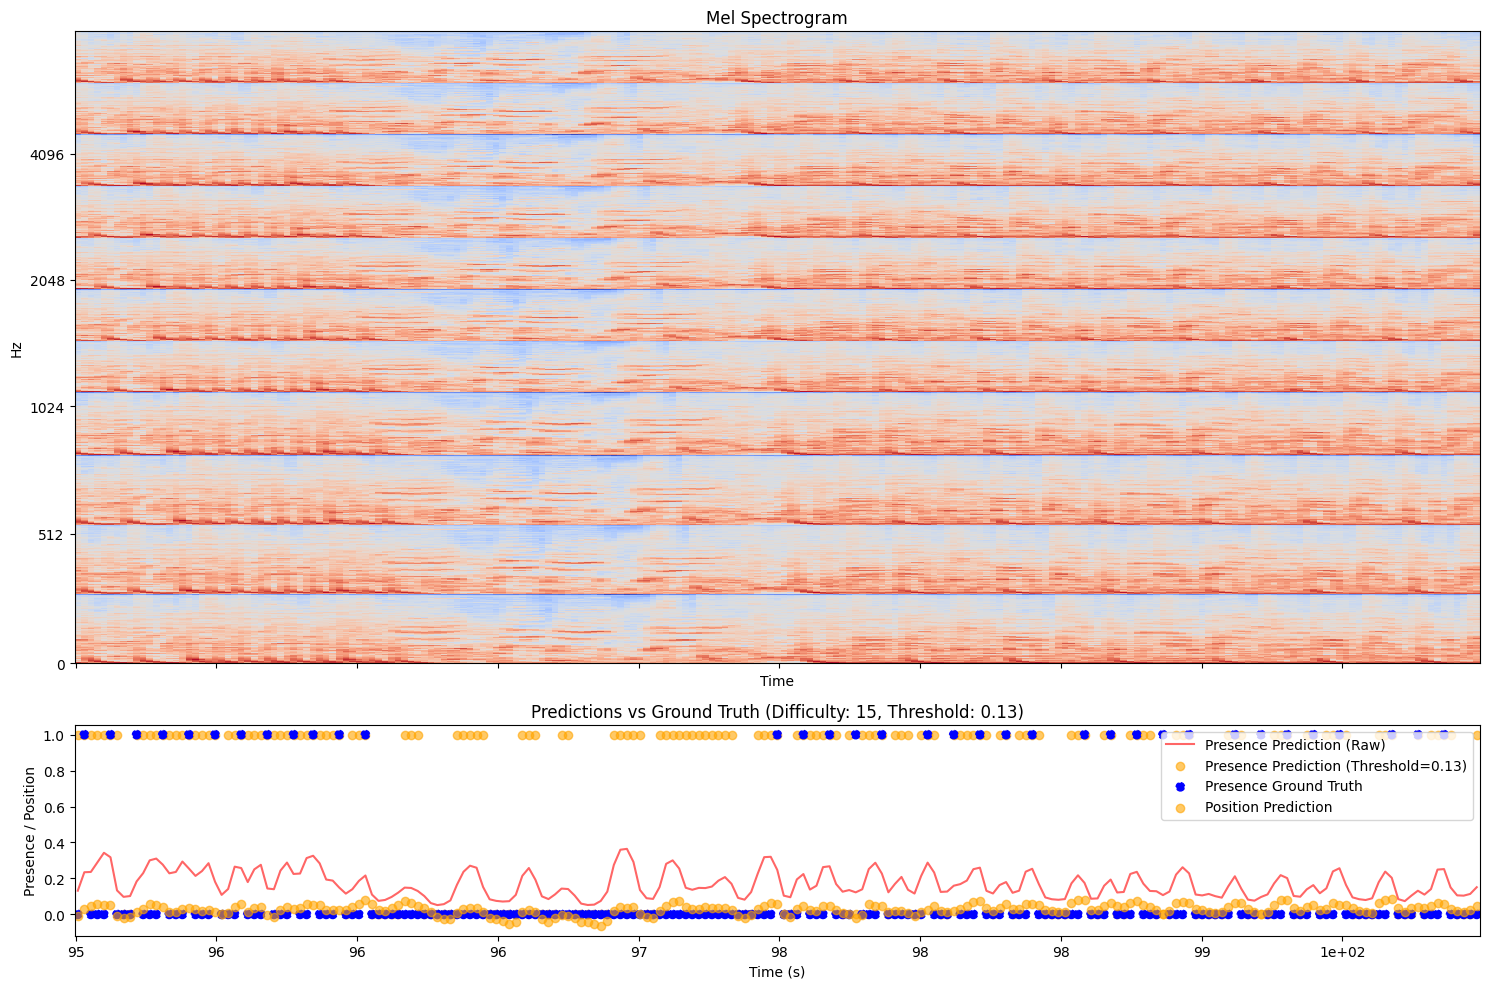

In [2]:
# %
# 可视化结果
def visualize_predictions_with_threshold(mel: np.ndarray, labels: np.ndarray, preds: Tuple[np.ndarray, np.ndarray, np.ndarray], difficulty: int, threshold: float, start_time: float = 0, end_time: float = 5):
    """
    可视化模型的预测结果与真实标签，并应用阈值。
    
    Args:
        mel (np.ndarray): Mel频谱图，形状为 (seq_len, feature_dim)
        labels (np.ndarray): 真实标签，形状为 (seq_len, 3)
        preds (Tuple[np.ndarray, np.ndarray, np.ndarray]): 模型预测的三个输出 (presence_pred, type_pred, position_pred)
        difficulty (int): 难度级别编码
        threshold (float): 对应难度级别的阈值
        start_time (float): 可视化的开始时间（秒）
        end_time (float): 可视化的结束时间（秒）
    """
    presence_pred, type_pred, position_pred = preds

    # 应用阈值
    presence_final = (presence_pred >= threshold).astype(int)

    # 计算时间轴
    total_time = mel.shape[0] * HOP_LENGTH / SAMPLE_RATE
    times = np.linspace(0, total_time, num=mel.shape[0])

    # 确定可视化的帧范围
    start_frame = int(start_time * SAMPLE_RATE / HOP_LENGTH)
    end_frame = int(end_time * SAMPLE_RATE / HOP_LENGTH)

    # 裁剪数据
    mel_cropped = mel[start_frame:end_frame]
    labels_cropped = labels[start_frame:end_frame]
    presence_pred_cropped = presence_pred[start_frame:end_frame]
    presence_final_cropped = presence_final[start_frame:end_frame]
    type_pred_cropped = type_pred[start_frame:end_frame]
    position_pred_cropped = position_pred[start_frame:end_frame]

    # 创建子图
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # 绘制Mel频谱图
    img = librosa.display.specshow(
        mel_cropped.T,
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        x_coords=times[start_frame:end_frame],
        ax=axs[0],
        x_axis='time',
        y_axis='mel',
        fmax=8000
    )
    axs[0].set_title('Mel Spectrogram')
    # fig.colorbar(img, ax=axs[0], format='%+2.0f dB')

    # 绘制Presence预测与真实标签
    axs[1].plot(
        times[start_frame:end_frame],
        presence_pred_cropped.flatten(),
        label='Presence Prediction (Raw)',
        color='red',
        alpha=0.6
    )
    axs[1].scatter(
        times[start_frame:end_frame],
        presence_final_cropped,
        label=f'Presence Prediction (Threshold={threshold:.2f})',
        color='orange',
        alpha=0.6
    )
    axs[1].scatter(
        times[start_frame:end_frame],
        labels_cropped[:, 0],
        label='Presence Ground Truth',
        color='blue',
        linestyle='dashed'
    )

    # 绘制Type预测与真实标签
    # 假设type_pred是类别的概率分布，这里我们取概率最高的类别
    type_pred_labels = np.argmax(type_pred_cropped, axis=-1)
    type_target_labels = labels_cropped[:, 1].astype(int)

    # 绘制Type Ground Truth
    # axs[1].scatter(
    #     times[start_frame:end_frame],
    #     labels_cropped[:, 2],  # 位置
    #     label='Type Ground Truth',
    #     color='green',
    #     marker='x'
    # )

    # 绘制Type Prediction（可以根据需要调整）
    axs[1].scatter(
        times[start_frame:end_frame],
        position_pred_cropped.flatten(),  # 位置预测
        label='Position Prediction',
        color='orange',
        marker='o',
        alpha=0.6
    )

    axs[1].set_title(f'Predictions vs Ground Truth (Difficulty: {difficulty}, Threshold: {threshold:.2f})')
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Presence / Position')

    plt.tight_layout()
    plt.show()

# %%
# 加载最佳模型
model.load_state_dict(torch.load("best_multitask_lstm_model.pth"))
model.to(device)
model.eval()

# %%
# 获取一个样本进行预测和可视化
sample_mel, sample_labels, sample_difficulty = dataset[0]
sample_mel_np = sample_mel.numpy()
sample_labels_np = sample_labels.numpy()

# 预测
with torch.no_grad():
    mel_tensor = sample_mel.unsqueeze(0).to(device)  # (1, seq_len, input_size)
    presence_pred, type_pred, position_pred = model(mel_tensor)
    presence_pred = presence_pred.squeeze(0).cpu().numpy()  # (seq_len, 1)
    type_pred = type_pred.squeeze(0).cpu().numpy()          # (seq_len, num_types)
    position_pred = position_pred.squeeze(0).cpu().numpy()  # (seq_len, 1)

# 加载阈值
thresholds = load_thresholds("difficulty_thresholds.pkl")
sample_difficulty_encoded = int(sample_difficulty.numpy()[0][0])
threshold_for_sample = thresholds.get(sample_difficulty_encoded, 0.5)

# 可视化
visualize_predictions_with_threshold(
    mel=sample_mel_np,
    labels=sample_labels_np,
    preds=(presence_pred, type_pred, position_pred),
    difficulty=sample_difficulty_encoded,
    threshold=threshold_for_sample,
    start_time=95,
    end_time=100
)
